In [1]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

from pandasgui import show

#

import warnings

In [2]:
warnings.filterwarnings( 'ignore' )

In [3]:
gmID_list = cfs.list_whitelisted_gmIDs()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [4]:
def MovingFunction( df, moving_colname, window, operation, desired_colnames ):

    if ( operation == 'mean' ):

        def operation_func( arraylike_obj ): return np.mean( arraylike_obj )

    elif ( operation == 'median' ):

        def operation_func( arraylike_obj ): return np.median( arraylike_obj )

    elif ( operation == 'overall_diff' ):

        def operation_func( arraylike_obj ): return ( arraylike_obj[ -1 ] - arraylike_obj[ 0 ] )

    elif ( operation == 'mean_diff' ):

        def operation_func( arraylike_obj ): 

            if ( len( arraylike_obj ) > 1 ):

                return ( np.mean( np.diff( arraylike_obj ) ) )

            elif ( len( arraylike_obj ) == 1 ):

                return 0

    elif ( operation == 'stddev' ):

        def operation_func( arraylike_obj ): return ( np.std( arraylike_obj ) )

    #

    moving_col = np.array( df[ moving_colname ] )

    moving_col_diff = np.diff( moving_col )

    #
    
    desired_cols = [ np.array( df[ desired_colname ] ) for desired_colname in desired_colnames ]

    #

    output_colnames = [ f'{ desired_colname }_{ operation }' for desired_colname in desired_colnames ]

    #

    window_indexes_list = []

    for index in range( 1, len( moving_col ) ):

        window_end_index = index - 1

        #

        value_sum = moving_col_diff[ window_end_index ]

        window_start_index = window_end_index

        while ( ( value_sum < window ) and ( window_start_index > 0 ) ):

            window_start_index = window_start_index - 1

            value_sum = value_sum + moving_col_diff[ window_start_index ]

        #

        window_indexes = [ i for i in range( window_start_index, window_end_index + 1 ) ]

        window_indexes_list.append( window_indexes )

    window_indexes_list = [ window_indexes_list[ 0 ] ] + window_indexes_list

    #

    output_cols = []

    for desired_col in desired_cols:

        output_col = []

        for window_indexes in window_indexes_list:

            output_col.append( operation_func( desired_col[ window_indexes ] ) )

        output_cols.append( output_col )

    #

    for output_colname, output_col in zip( output_colnames, output_cols ):

        df[ output_colname ] = output_col  

In [5]:
def BinaryDisengagement( df ):

    TernaryDrivingModeTransition_col = df[ 'TernaryDrivingModeTransition' ]

    BinaryDisengagement_col = []

    for val in TernaryDrivingModeTransition_col:

        if ( ( val == 0 ) or ( val == 1 ) ):

            BinaryDisengagement_col.append( 0 )

        elif ( val == -1 ):

            BinaryDisengagement_col.append( 1 )

    df[ 'BinaryDisengagement' ] = BinaryDisengagement_col

In [6]:
def BinaryDisengagementExpanded( df, moving_colname, window ):

    moving_col = np.array( df[ moving_colname ] )

    moving_col_diff = np.diff( moving_col )

    #

    BinaryDisengagement_col = np.array( df[ 'BinaryDisengagement' ] )

    disengagement_indexes = np.where( BinaryDisengagement_col == 1 )[ 0 ]

    #
    
    window_indexes_list = []

    for index in disengagement_indexes:
        
        window_indexes = [ index ]

        cur_loop_index = index - 1

        value_sum = moving_col_diff[ cur_loop_index ]

        while ( ( value_sum <= window ) and ( cur_loop_index > -1 ) ):

            window_indexes = [ cur_loop_index ] + window_indexes

            #

            cur_loop_index = cur_loop_index - 1

            value_sum = value_sum + moving_col_diff[ cur_loop_index ]

        window_indexes_list.append( window_indexes )

    #

    BinaryDisengagementExpanded_col = np.copy( BinaryDisengagement_col )

    for window_indexes in window_indexes_list:

        BinaryDisengagementExpanded_col[ window_indexes ] = 1

    #

    df[ 'BinaryDisengagementExpanded' ] = BinaryDisengagementExpanded_col

In [7]:
def Index( df ):

    num_of_rows = df.shape[ 0 ]

    df[ 'Ind' ] = [ index for index in range( num_of_rows ) ]

In [8]:
def Distance( df ):

    time_array = np.array( df[ 'time' ] ) * 1e-9 # seconds

    speedMps_array = np.array( df[ 'speedMps' ] ) # meters/second

    #

    deltatime_array = np.diff( time_array )

    deltatime_array = np.insert( deltatime_array, 0, deltatime_array[ 0 ] )

    #

    deltadistance_array = deltatime_array * speedMps_array #meters

    Distance_col = np.cumsum( deltadistance_array )

    #

    df[ 'Distance' ] = Distance_col

In [9]:
def DisengagementID( df, expanded = False ):

    gmID = df[ 'groupMetadataID' ][ 0 ]
    
    #

    if ( expanded == False ):

        disengagment_col = np.array( df[ 'BinaryDisengagement' ] )

        string1 = ''

        string2 = ''

    elif ( expanded == True ):

        disengagment_col = np.array( df[ 'BinaryDisengagementExpanded' ] )

        string1 = 'Expanded'

        string2 = 'e'

    #

    disengagement_indexes = np.where( disengagment_col == 1 )[ 0 ]

    #

    DisengagementID_col = [ 'NAD' for i in disengagment_col ]

    counter = 0

    for index in disengagement_indexes:

        DisengagementID_col[ index ] = f'{ gmID }_{ counter }{ string2 }'

        counter = counter + 1

    df[ f'Disengagement{ string1 }ID' ] = DisengagementID_col

In [18]:
gmID = gmID_list[ 0 ]

chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

chassis_df = chassis_df.sort_values( 'time' )

best_pose_df = best_pose_df.sort_values( 'time' )

#

Index( chassis_df )

#

cfs.BinaryDrivingMode( chassis_df )

cfs.TernaryDrivingModeTransition( chassis_df )

BinaryDisengagement( chassis_df )

BinaryDisengagementExpanded( chassis_df, moving_colname = 'time', window = 1e9 )

#

DisengagementID( chassis_df, expanded = False )

DisengagementID( chassis_df, expanded = True )

#

cfs.Acceleration( chassis_df )

#

Distance( chassis_df )

#

cfs.LatLonTotalStdDev( best_pose_df )

#

cfs.ProgressAlongRoute_v2( best_pose_df )

#

cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

#

combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

#

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54411 entries, 0 to 54410
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   brakePercentage               54411 non-null  float64
 1   groupMetadataID_x             54411 non-null  object 
 2   drivingMode                   54411 non-null  object 
 3   speedMps                      54411 non-null  float64
 4   time_x                        54411 non-null  int64  
 5   throttlePercentage            54411 non-null  float64
 6   steeringPercentage            54411 non-null  float64
 7   signal.turnSignal             54411 non-null  object 
 8   Ind                           54411 non-null  int64  
 9   BinaryDrivingMode             54411 non-null  int64  
 10  TernaryDrivingModeTransition  54411 non-null  int64  
 11  BinaryDisengagement           54411 non-null  int64  
 12  BinaryDisengagementExpanded   54411 non-null  int64  
 13  D

In [19]:
columns_to_keep = [ 'Ind', 'brakePercentage', 'groupMetadataID_x', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', 
                    'BinaryDrivingMode', 'TernaryDrivingModeTransition', 'BinaryDisengagement', 'BinaryDisengagementExpanded',
                    'DisengagementID', 'DisengagementExpandedID', 'Acceleration', 'Distance', 'longitude', 'latitude', 
                    'LatLonTotalStdDev', 'ProgressAlongRoute' ]

combined_df = combined_df[ columns_to_keep ]

#

combined_df = combined_df.rename( columns = { 'groupMetadataID_x': 'groupMetadataID', 'time_x': 'time' } )

#

combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54411 entries, 0 to 54410
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ind                           54411 non-null  int64  
 1   brakePercentage               54411 non-null  float64
 2   groupMetadataID               54411 non-null  object 
 3   speedMps                      54411 non-null  float64
 4   time                          54411 non-null  int64  
 5   throttlePercentage            54411 non-null  float64
 6   steeringPercentage            54411 non-null  float64
 7   BinaryDrivingMode             54411 non-null  int64  
 8   TernaryDrivingModeTransition  54411 non-null  int64  
 9   BinaryDisengagement           54411 non-null  int64  
 10  BinaryDisengagementExpanded   54411 non-null  int64  
 11  DisengagementID               54411 non-null  object 
 12  DisengagementExpandedID       54411 non-null  object 
 13  A

In [27]:
desired_colnames = [ 'speedMps', 'Acceleration', 'brakePercentage', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev' ]

MovingFunction( combined_df, moving_colname = 'time', window = ( 10 * 1e9 ), operation = 'median', desired_colnames = desired_colnames )

In [28]:
print( np.where( combined_df[ 'BinaryDisengagement' ] == 1 ) )

(array([21675, 37742, 46673]),)


In [29]:
show( combined_df )

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


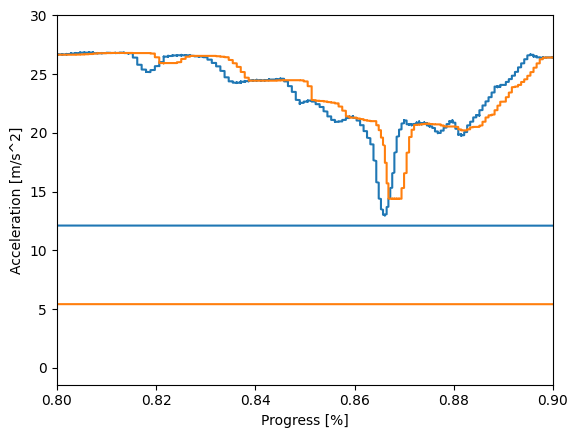

In [30]:
plt.plot( combined_df[ 'ProgressAlongRoute' ], combined_df[ 'speedMps' ] )

plt.plot( combined_df[ 'ProgressAlongRoute' ], combined_df[ 'speedMps_median' ] )

plt.xlabel( 'Progress [%]' )

plt.ylabel( 'Acceleration [m/s^2]' )

plt.xlim( 0.8, 0.9 )

plt.show()

In [10]:
combined_dfs = []

for gmID in gmID_list:

    chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    chassis_df = chassis_df.sort_values( 'time' )

    best_pose_df = best_pose_df.sort_values( 'time' )

    #

    cfs.Acceleration( chassis_df, time_interval = 1 / 3 )

    cfs.BinaryDrivingMode( chassis_df )

    cfs.TernaryDrivingModeTransition( chassis_df )

    cfs.DistanceToNearestDisengagement( chassis_df )

    #

    cfs.LatLonTotalStdDev( best_pose_df )

    cfs.ProgressAlongRoute_v2( best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

    #

    combined_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    #

    combined_df = combined_df[ [ 'groupMetadataID_x', 'brakePercentage', 'speedMps', 'time_x', 'throttlePercentage', 'steeringPercentage', \
                                 'TernaryDrivingModeTransition', 'DistanceToNearestDisengagement', 'NearestDisengagementID', \
                                 'longitude', 'latitude', 'LatLonTotalStdDev', 'ProgressAlongRoute', 'PartitionNumber', 'Acceleration' ] ]

    combined_dfs.append( combined_df )

In [11]:
combined_df_all = pd.concat( combined_dfs )

del combined_dfs

In [15]:
combined_df_all[ 'steeringPercentage' ] = np.abs( combined_df_all[ 'steeringPercentage' ] )

In [17]:
max_LatLonTotalStdDev = 10 #Free Variable 1

#

limited_stddev_list = []

for stddev in combined_df_all[ 'LatLonTotalStdDev' ]:

    if ( stddev > max_LatLonTotalStdDev ):

        stddev = max_LatLonTotalStdDev

    limited_stddev_list.append( stddev )

combined_df_all[ 'LatLonTotalStdDev' ] = limited_stddev_list

In [18]:
search_dist_behind_disengagement = 50 #m #Free Variable 1

combined_df_all_sliced = combined_df_all[ ( combined_df_all[ 'DistanceToNearestDisengagement' ] > -search_dist_behind_disengagement ) &
                                          ( combined_df_all[ 'DistanceToNearestDisengagement' ] < 0 ) ]